In [2]:
from operator import index
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import math
import logging
import numpy as np
import seaborn as sns
from pycparser.c_ast import Break
from setuptools.command.build_ext import if_dl
from setuptools.command.rotate import rotate

import index_definition
import index_utils as ai
from confidence_index import get_index_cut_by_time
from train_online_model import predict, generate_live_match_data
import warnings
import common
import dill
import confidence_index as ci

# 忽略所有警告
warnings.filterwarnings("ignore")
# logging.basicConfig(
#     level=logging.INFO,  
#     format='%(asctime)s [简记] %(message)s',  # 去除非必要字段
#     handlers=[
#         logging.StreamHandler(), 
#         logging.FileHandler('data_analysis.log') 
#     ]
# )

data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
gameids = data['gameid'].unique()

In [ ]:
 #探究信心指数对比赛结果的影响

gameids = gameids[0:4]

team_feature_df = get_index_cut_by_time(data, gameids, index_definition.CONFIDENCE_INDEX, 120, tfrom=0, to=3600)
max_cols = 2  #每行最多显示2张
num_plots = len(gameids) * 2
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
sns.set_theme(style="dark")

for i in range(len(gameids)):
    gameid = gameids[i]
    j = i * 2 if i > 0 else 0
    winner = common.get_winner(data, gameid)
    winnerid = winner[0]
    loserid = winner[1]
    winner_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == winnerid)]
    winner_goal = winner_df[winner_df['goal'] == 1]['elapsed_sec'].values
    loser_df = team_feature_df[(team_feature_df['gameid'] == gameid) & (team_feature_df['teamid'] == loserid)]
    loser_goal = loser_df[loser_df['goal'] == 1]['elapsed_sec'].values
    feature_names = ['accuracy_reception_succ', 'accuracy_pass_succ', 'efficient_block_succ', 'body_check']
    colors = sns.color_palette("bright", n_colors=len(feature_names))
    ax = plt.subplot(rows, cols, j + 1)
    ax0 = plt.subplot(rows, cols, j + 2)
    for c, (f, color) in enumerate(zip(feature_names, colors)):
        sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
        ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
        # sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
        # ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
        for goal_time in winner_goal:
            ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
        # for goal_time in loser_goal:
        #     ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
    for c, (f, color) in enumerate(zip(feature_names, colors)):
        # sns.lineplot( x=list(winner_df['elapsed_sec']),y=list(winner_df[f]), color=color, label=f, ax=ax)
        # ax.set_title('Game:' + str(gameid) + 'WinnerTeamid:' + str(winnerid))
        sns.lineplot( x=list(loser_df['elapsed_sec']), y=list(loser_df[f]),color=color, label=f, ax=ax0)
        ax0.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
        # for goal_time in winner_goal:
        #     ax.vlines(x=goal_time, ymin=0, ymax=ax.get_ylim()[1], color='green', linestyles='-')
        for goal_time in loser_goal:
            ax0.vlines(x=goal_time, ymin=0, ymax=ax0.get_ylim()[1], color='green', linestyles='-')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
#所有比赛的整体数据分析
events = {**index_definition.CONTEST,**index_definition.GOAL, **index_definition.PASS, **index_definition.SHOT, **index_definition.BLOCK,**index_definition.CHECK, }
max_cols = 2  #每行最多显示2张
num_plots = len(events) 
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
normal_time_df = data[(data['compiledgametime'] <= 3600)]
for index, (event_name, event) in enumerate(events.items()):
    ax = plt.subplot(rows, cols, index+1)
    condition = normal_time_df.eval(event)
    event_df = normal_time_df[condition]
    bin_inter = 180
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    labels = bins[0:20]
    event_df['cut'] = pd.cut(event_df['compiledgametime'], bins=bins, labels=labels)
    sns.countplot(x='cut', hue='eventname', data=event_df,ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(event_name)
    ax.set_xlabel('Time')
    ax.set_ylabel(event_name + ' Number')
    ax.legend(title=event_name)


plt.tight_layout()
# 显示图表
plt.show()

In [ ]:
#比赛0到540秒,即前9分钟,相比较与其他时间段进球的队伍，首先进球队伍的胜率非常低，只有48%，输掉比赛的概率有41%，
# 其他时间段内普遍在60%以上，其中在后半场开场后一段时间内，进球队伍胜率最高，达到了70%以上
start_time = 0
end_time =  600
total_games = 0
first_goal_win_teams = 0
first_goal_home_win_teams = 0
first_goal_win_tie_teams =0
first_goal_lost_teams = 0
special_time_df =  data[(data['compiledgametime'] <= end_time) & (data['compiledgametime'] >= start_time) & (data['eventname'] == 'goal')]
grouped = special_time_df.groupby('gameid')
for gameid, gamedata in grouped:
    total_games += 1
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    goal_team = gamedata['teaminpossession'].unique()
    #如果这个时间段两个队伍都进球了，只计算第一个进球的队伍
    if len(goal_team) == 2:
        goal_team = gamedata.iloc[0]['teaminpossession']
    else:
        goal_team =gamedata['teaminpossession'].unique()[0]
    if goal_team == winner[0]: #至少比赛是平局
        first_goal_win_tie_teams += 1
        if  winner[2] is True: #比赛不是平局
            first_goal_win_teams += 1
            if winner[0] == home_team_id:
                first_goal_home_win_teams += 1
    else:
        first_goal_lost_teams += 1
print('总比赛场次:', total_games,',至少平局场次:', first_goal_win_tie_teams, ',赢下比赛场次:', first_goal_win_teams, '输掉比赛场次:', first_goal_lost_teams)
print('至少平局的概率:', first_goal_win_tie_teams / total_games)
print('赢下比赛的概率:', first_goal_win_teams / total_games)
print('是主队且赢下比赛的概率:', first_goal_home_win_teams / total_games)
print('输掉比赛的概率:', first_goal_lost_teams / total_games)


#探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.



In [ ]:
##探究控所有比赛主队和客队的球率
#发现主队在开场9分钟内控球率最高，客队在开场9分钟内控球率最低，结合上面的分析，可以看出主队在开场9分钟内控球率高，如果进球,赢球的概率却最低.
bin_inter = 90
plt.figure(figsize=(10, 3))
bin_number = int(3600 / bin_inter)
unique_gameids = data['gameid'].unique()
gameids = unique_gameids[0:156]
home_total_control_times = [0] * bin_number
visit_total_control_times = [0] * bin_number
home_total_control_rates = [0] * bin_number
visit_total_control_rates = [0] * bin_number
game_first_period_control_rate= {}
game_all_period_control_times= {}
#按队伍计算每个时间段的控球率
game_total_control_rates = {}
for gameid in gameids:
    gamedata = data[(data['gameid'] == gameid)]
    game_home_total_control_times = [0] * bin_number
    game_visit_total_control_times = [0] * bin_number
    bins = list(np.arange(0, 3600, bin_inter))
    bins.append(3600)
    for i in range(len(bins)):
        if i + 1 == len(bins):
            game_first_period_control_rate[gameid] = game_home_total_control_times[0] / (
                        game_home_total_control_times[0] + game_visit_total_control_times[0])
            game_total_control_rates[gameid] = sum(game_home_total_control_times) / (
                        sum(game_home_total_control_times) + sum(game_visit_total_control_times))
            game_all_period_control_times[gameid]= [game_home_total_control_times, game_visit_total_control_times]
            break
        tfrom = bins[i]
        to = bins[i + 1]
        home_control_rate, visit_control_rate, home_possession_time, visit_possession_time = common.get_control_rate0(
            data, gameid, tfrom, to)
        home_total_control_times[i] = sum(home_possession_time) + home_total_control_times[i]
        visit_total_control_times[i] = sum(visit_possession_time) + visit_total_control_times[i]
        home_total_control_rates[i] = home_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        visit_total_control_rates[i] = visit_total_control_times[i] / (
                    home_total_control_times[i] + visit_total_control_times[i])
        game_home_total_control_times[i] = sum(home_possession_time) 
        game_visit_total_control_times[i] = sum(visit_possession_time) 
plt.title('Home team puck control rate')
sns.lineplot(x=bins[1:], y=home_total_control_rates, color='r', label='Home Team')
sns.lineplot(x=bins[1:], y=visit_total_control_rates, color='b', label='Visit Team')
plt.legend()
plt.show()


In [ ]:
# 控球率与比赛结果的关系，按时间和比赛计算

max_cols = 2  #每行最多显示2张
num_plots = 20
rows = (num_plots + max_cols - 1) // max_cols
cols = min(max_cols, num_plots)
plt.figure(figsize=(15, rows * 3))
sns.set_theme(style="dark")
for index, (gameid, game_control_times) in enumerate(game_all_period_control_times.items()):
    if index == num_plots - 1 : break
    home_control_times = game_control_times[0]
    visit_control_times = game_control_times[1]
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data,gameid)
    winnerid = winner[0]
    loserid = winner[1]
    ax = plt.subplot(rows, cols, index + 1)
    sns.lineplot(x=bins[1:], y=home_control_times, color='r', label='Home Team', ax=ax)
    title = 'Game:' + str(gameid) + ',Winner=Home Team'  if winnerid == home_team_id else 'Game:' + str(gameid) + ',Winner=Visit Team'
    if winner[2] is False:
        ax.set_title('Game:' + str(gameid) + ',Winner=Home Team(Tie)')
    else:
        ax.set_title(title)
    # ax0 = plt.subplot(rows, cols, index * 2 + 2)
    sns.lineplot(x=bins[1:], y=visit_control_times, color='b', label='Visit Team', ax=ax)
    # ax.set_title('Game:' + str(gameid) + 'LoseTeamid:' + str(loserid))
plt.legend()
plt.tight_layout()
# 显示图表
plt.show()



In [ ]:

#所以，我们有个猜想，第一节耗能最多的球队，反而最后会输掉比赛
#耗能的event数量太多，不一一分析，这里只分析一个event，即body_check
#看看第一节Body check和胜率的关系
# body_check_df =  data[(data['compiledgametime'] <= end_time) & (data['compiledgametime'] >= start_time) & (data['eventname'] == 'check') & (data['type'] == 'body')]
# max_cols = 2  #每行最多显示2张
# num_plots = 50
# rows = (num_plots + max_cols - 1) // max_cols
# cols = min(max_cols, num_plots)
# plt.figure(figsize=(15, rows * 3))
# sns.set_theme(style="dark")
grouped = data.groupby('gameid')
gameids = unique_gameids.tolist()
detail_df = ci.get_index_cut_by_time(data, gameids, {**index_definition.BODY, **index_definition.CONTEST},
                                    time_interval=180)
#计算前9分钟body的次数，以及比赛的结果
detail_df = detail_df[(detail_df['elapsed_sec'] <= 1200) & (detail_df['elapsed_sec'] >= 540)]
game_check_dict = {}
more_body_win = 0
less_body_win = 0
tie = 0
other = 0
for gameid in gameids:
    game_df = detail_df[detail_df['gameid'] == gameid]
    team_ids = game_df['teamid'].unique().tolist()
    game_check_dict[gameid] = {}
    for teamid in team_ids:
        team_df = game_df[game_df['teamid'] == teamid]
        body_event_sum = team_df['contest'].sum()
        game_check_dict[gameid][teamid] = body_event_sum

for gameid, value in game_check_dict.items():
    winner = common.get_winner(data, gameid)
    home_team_id = common.get_home_team_id(data, gameid)
    teamids = list(value.keys())
    body_sums = list(value.values())
    if body_sums[0] > body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            more_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            less_body_win += 1
        elif winner[2] is False:
            tie += 1
    elif body_sums[0] < body_sums[1]:
        if winner[0] == teamids[0] and winner[2] is True:
            less_body_win += 1
        elif winner[0] == teamids[1] and winner[2] is True:
            more_body_win += 1
        elif winner[2] is False:
            tie += 1
print("其他情况数量:" + str(other))
print("平局数量:" + str(tie))
print("第一节更少的body check的队伍赢得比赛数量:" + str(less_body_win))
print("第一节更多的body check的队伍赢得比赛数量:" + str(more_body_win))
print("第一节更少的body check的队伍赢得比赛的概率是：" + str(less_body_win / len(gameids)))
print("第一节更多的body check的队伍赢得比赛的概率是：" + str(more_body_win / len(gameids)))



In [10]:
data = pd.read_csv("Linhac24-25_Sportlogiq.csv")
data['inopponentarea'] = data.apply(common.puck_location, axis=1)
unique_gameids = data['gameid'].unique()
gameids = unique_gameids.tolist()

In [ ]:
#整理数据，提取特征
#包括两大类，一类是会影响体力的要素，一类是会影响信心指数的要素，两者也有重合的部分，比如成功的扑救会提高信心，但是会降低守门员的体力
#这里我暂时把SAVE这个动作放入影响体力要素里面

all_events_index = {**index_definition.EXERTION_INDEX, **index_definition.CONFIDENCE_INDEX}
#将第一节时间也分成两个部分,一个是0到540秒，一个是540到1200秒

first_period_index_df1 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 0, to = 540)
first_period_index_df2 =ci.get_index_cut_by_time(data, gameids, all_events_index, 180,tfrom = 540, to = 1200)

def extract_features(df, suffix, events,tfrom,to):
    event_names = list(events.keys())
    event_names = [str(item) + '_succ' for item in event_names] + event_names
    grouped = df.groupby(['gameid','teamid'])
    res = pd.DataFrame()
    for name, group in grouped:
        gameid = name[0]
        teamid = name[1]
        home_team_id = common.get_home_team_id(data, gameid)
        winner = common.get_winner(data,gameid)
        team_df = group[event_names]
        team_df.iloc[0] = team_df.sum()
        team_df = team_df.add_suffix(suffix)
        # 仅保留第一行
        team_df = team_df.iloc[[0]]
        team_df['gameid'] = gameid
        team_df['teamid'] = teamid
        team_df['score_diff' + suffix] = group.iloc[-1]['score_diff']
        team_df['is_home'] = 1 if teamid == home_team_id else 0
        #获取这段时间的控球率
        home_control_rate, visit_control_rate, home_possession_time, visit_possession_time =common.get_control_rate0(data, gameid, tfrom, to)
        team_df['control_rate' + suffix] = home_control_rate if teamid == home_team_id else visit_control_rate
        team_df['control_time' + suffix] = sum(home_possession_time) if teamid == home_team_id else sum(visit_possession_time)
        team_df['win'+ suffix] = 0 if winner[2] is False else 1 if winner[0] == teamid else -1 
        res = team_df if res.empty else pd.concat([res, team_df], axis=0)
    return res

res1 = extract_features(first_period_index_df1,"_p1", all_events_index, 0, 540)
res2 = extract_features(first_period_index_df2, "_p2",all_events_index, 540, 1200)

res1.drop(columns=['win_p1'],inplace=True)
merge_res = res1.merge(res2, on= ['gameid','teamid','is_home'], how='left')
merge_res.rename(columns={'win_p2':'win'},inplace=True)


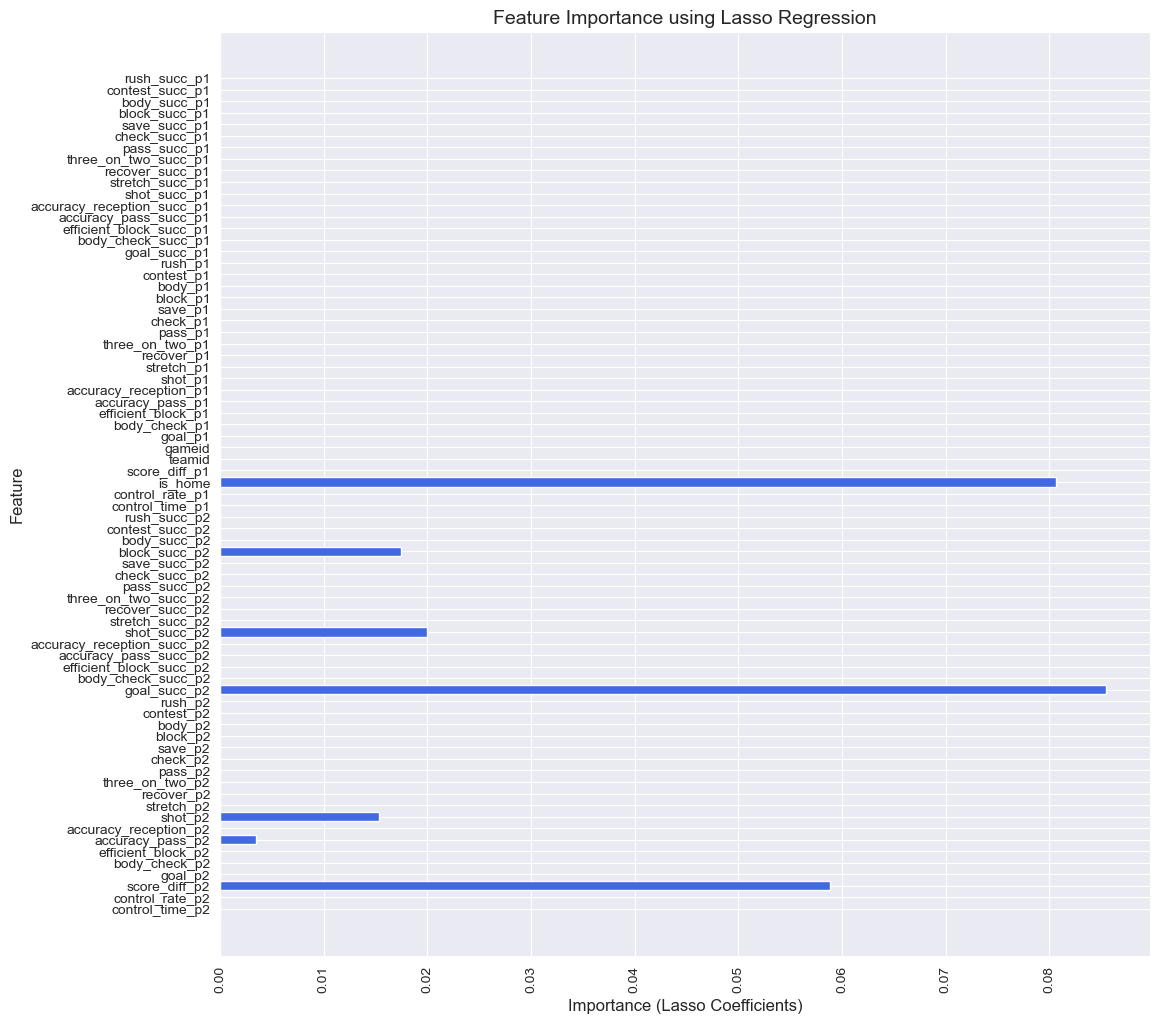

重要特征索引: [35 41 48 53 64 66 70]
对应的 Lasso 重要性系数: [ 0.08067919 -0.01744764  0.02001513  0.08542908  0.01533725  0.00343881
  0.05888018]


In [33]:
#使用多种机器学习模型进行训练
#首先使用lasso进行特征选择
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

X = merge_res.iloc[:,:-1]
y = merge_res['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# 3. 训练 Lasso 回归模型
lasso = Lasso(alpha=0.1)  # alpha 越大，正则化越强，更多系数趋于 0
lasso.fit(X_scaled, y_train)

# 4. 获取特征重要性（Lasso 回归的系数）
feature_importance = np.abs(lasso.coef_)
feature_names = X.columns  # 直接使用 DataFrame 的列名

# sorted_indices = np.argsort(feature_importance)[::-1]  # 按重要性降序排序
# sorted_features = X.columns[sorted_indices]
# sorted_importance = feature_importance[sorted_indices]


# 5. 可视化特征重要性
plt.figure(figsize=(12, 12))
plt.barh(range(len(feature_importance)), feature_importance, tick_label=feature_names, color='royalblue')
plt.xlabel("Importance (Lasso Coefficients)", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Feature", fontsize=12)
plt.title("Feature Importance using Lasso Regression", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)  # 缩小特征名称字体
plt.gca().invert_yaxis()  # 让重要特征排在上面
plt.show()

# 6. 打印最重要的特征
important_features = np.where(feature_importance > 0)[0]
print(f"重要特征索引: {important_features}")
print(f"对应的 Lasso 重要性系数: {lasso.coef_[important_features]}")




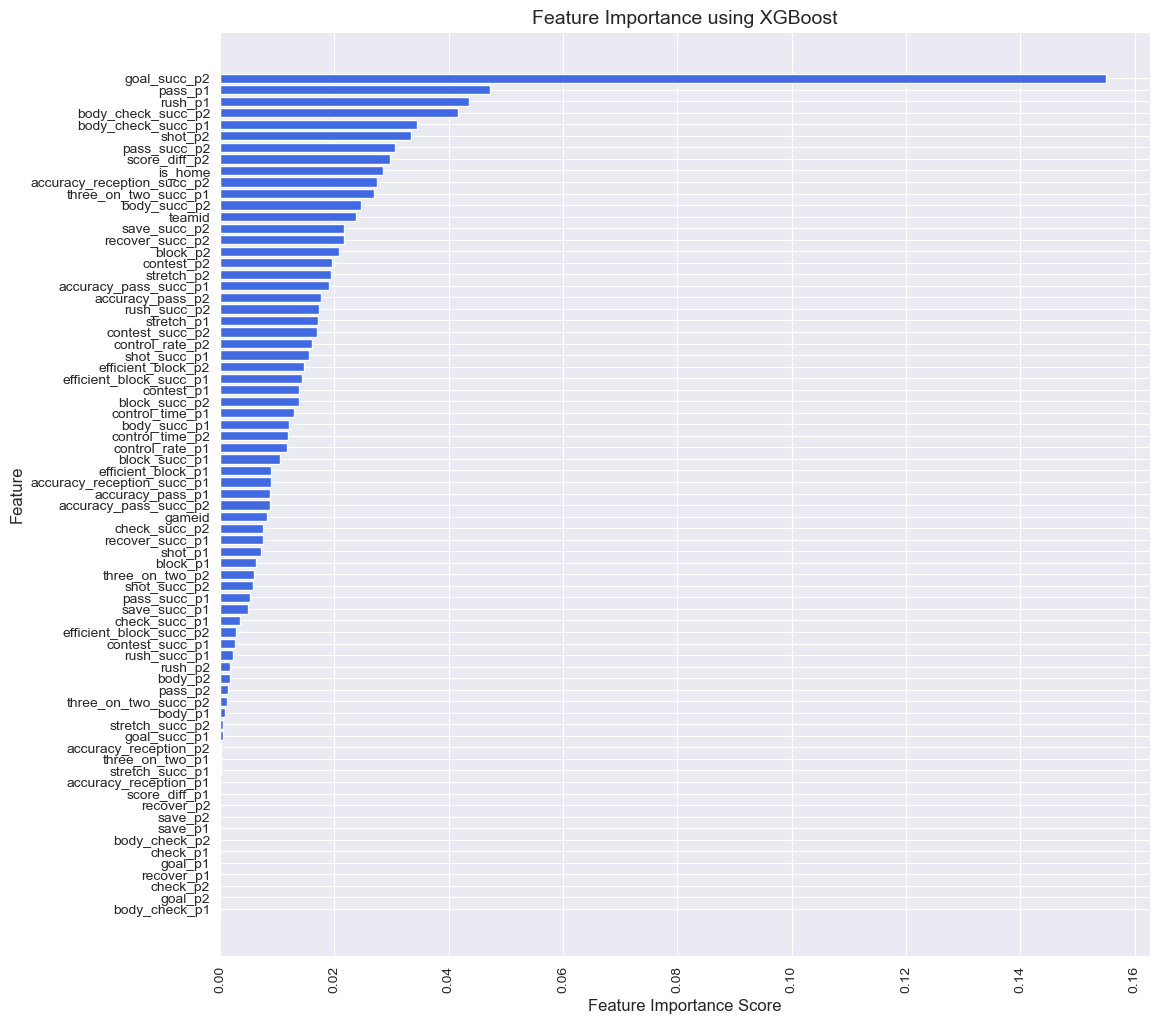

In [36]:
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importance = model.feature_importances_

sorted_indices = np.argsort(importance)[::-1]  # 按重要性降序排序
sorted_features = X.columns[sorted_indices]
sorted_importance = importance[sorted_indices]


plt.figure(figsize=(12, 12))
plt.barh(sorted_features, sorted_importance, color="royalblue")
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(rotation=90)
plt.title("Feature Importance using XGBoost", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()  # 让重要特征排在上方
plt.show()


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	71
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	71
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	71
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	71
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	72
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	72
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	72
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	72
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	1
Rejected: 	72
I

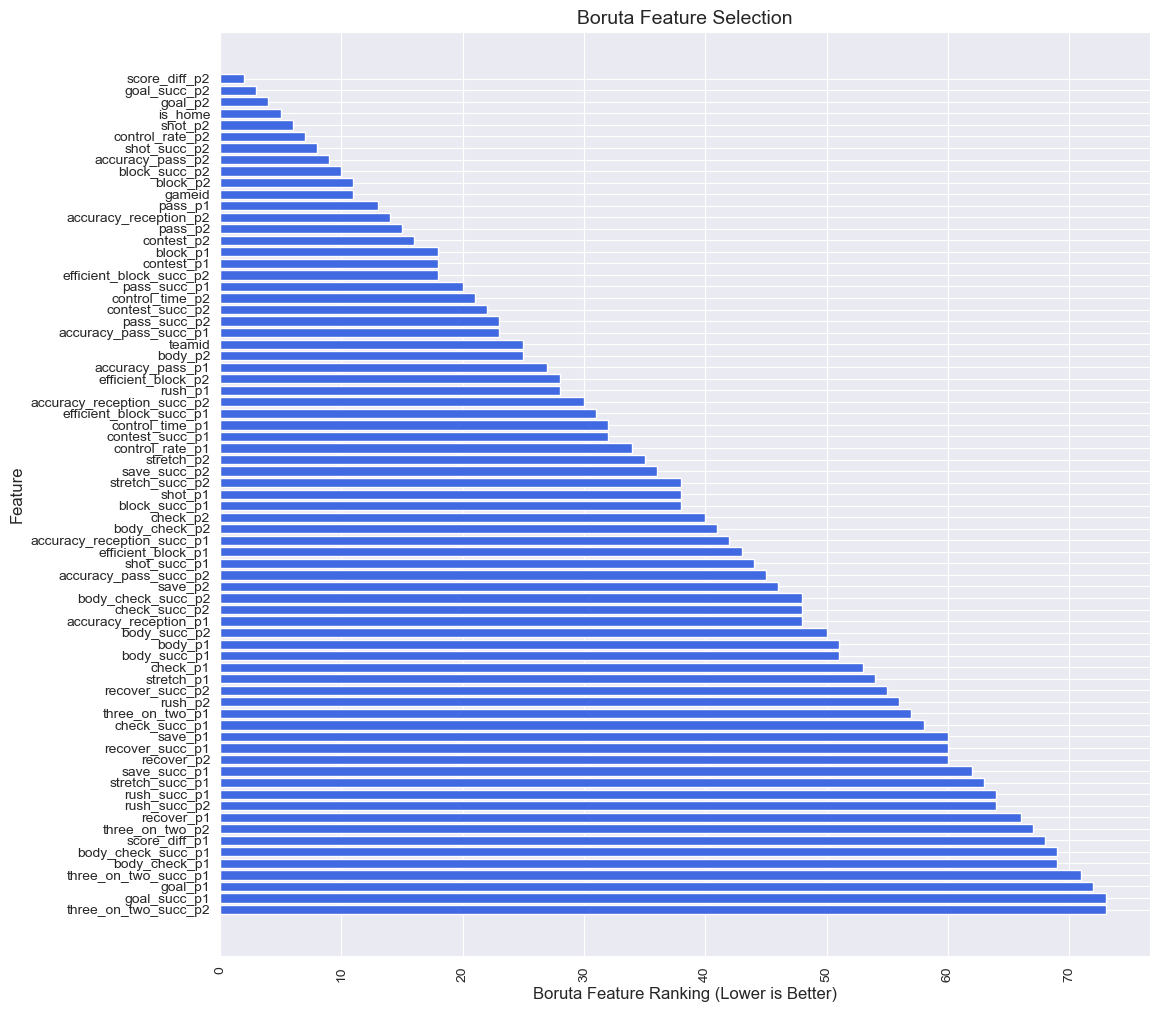

In [37]:
#Boruta算法筛选因子
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42)
boruta_selector = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42)
boruta_selector.fit(X_train, y_train)
# 5. 获取被选中的重要特征
selected_features = X.columns[boruta_selector.support_]
print(f"⭐ 选中的重要特征: {selected_features.tolist()}")

# 6. 获取被 Boruta 拒绝的特征
rejected_features = X.columns[boruta_selector.support_ == False]
print(f"🚫 被拒绝的特征: {rejected_features.tolist()}")

# 7. 绘制特征重要性对比
feature_ranks = boruta_selector.ranking_
sorted_idx = np.argsort(feature_ranks)

plt.figure(figsize=(12, 12))
plt.xticks(rotation=90)
plt.barh(X.columns[sorted_idx], feature_ranks[sorted_idx], color="royalblue")
plt.xlabel("Boruta Feature Ranking (Lower is Better)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Boruta Feature Selection", fontsize=14)
plt.gca().invert_yaxis()
plt.show()